In [1]:
import os
import zipfile
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.core.pylabtools import figsize
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms,models
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
import time

<a href="https://colab.research.google.com/github/HazemAbdo/FloodSense/blob/classification%2Fdeep_learning/SI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python-headless

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helpers

In [4]:
def show_img(img,title=""):
      plt.imshow(img)
      plt.title(title)
      plt.show()

# Images reading 

In [5]:
# specify the path to your zip file
zip_path = "drive/MyDrive/Copy of dataset.zip"

# create a ZipFile object
with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    # extract all contents to a specified directory
    zip_ref.extractall("/content")

In [6]:
# specify the paths to the "flooded" and "non-flooded" ders
flooded_path = "dataset/flooded"
non_flooded_path = "dataset/non-flooded"

# create empty numpy arrays to store the images
# flooded = np.empty((0, 224, 224))
# non_flooded = np.empty((0, 224, 224))

# # loop through the images in the "flooded" der
# for filename in os.listdir(flooded_path):
#     img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (224, 224)) # resize the image to (224, 224)
#     img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
#     img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
#     flooded = np.concatenate((flooded, img), axis=0)

# # loop through the images in the "non-flooded" der
# for filename in os.listdir(non_flooded_path):
#     img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (224, 224)) # resize the image to (224, 224)
#     img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
#     img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
#     non_flooded = np.concatenate((non_flooded, img), axis=0)

flooded = np.empty((0, 224, 224, 3))
non_flooded = np.empty((0, 224, 224, 3))
# loop through the images in the "flooded" der
for filename in os.listdir(flooded_path):
    img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224)) # resize the image to (224, 224)
    img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
    img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
    flooded = np.concatenate((flooded, img), axis=0)

# loop through the images in the "non-flooded" der
for filename in os.listdir(non_flooded_path):
    img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224)) # resize the image to (224, 224)
    img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
    img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
    non_flooded = np.concatenate((non_flooded, img), axis=0)
  
print(flooded.shape)
print(non_flooded.shape)

(461, 224, 224, 3)
(461, 224, 224, 3)


In [7]:
flooded[0].shape

(224, 224, 3)

In [8]:
flooded_train, flooded_test = train_test_split(flooded, test_size=0.2, random_state=42)
non_flooded_train, non_flooded_test = train_test_split(non_flooded, test_size=0.2, random_state=42)
print(flooded_train.shape, flooded_test.shape) 
print(non_flooded_train.shape, non_flooded_test.shape) 

(368, 224, 224, 3) (93, 224, 224, 3)
(368, 224, 224, 3) (93, 224, 224, 3)


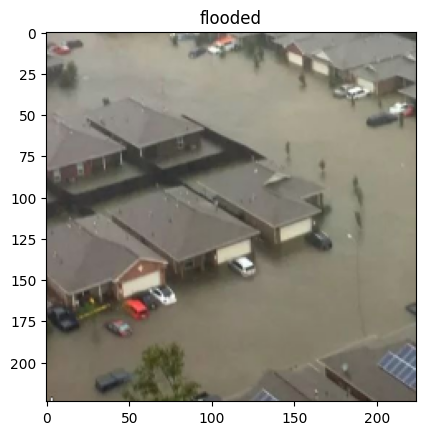

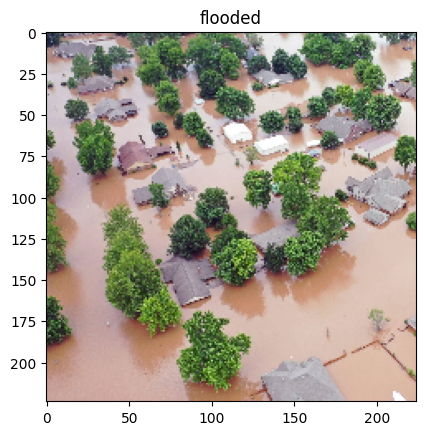

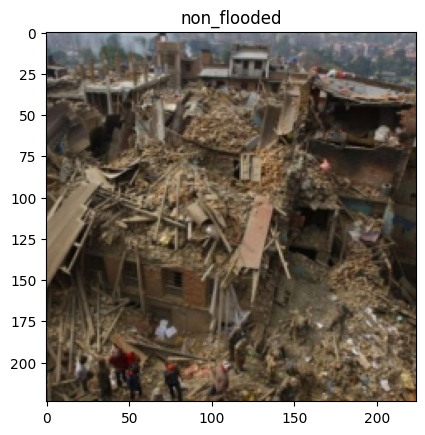

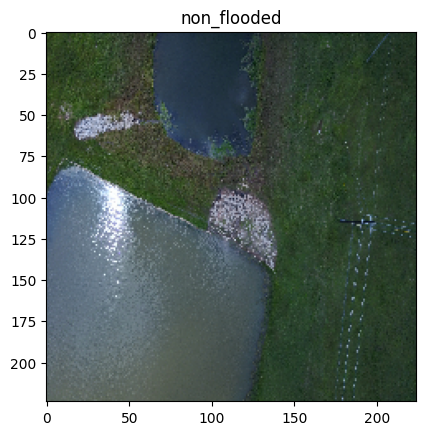

In [9]:
show_img(flooded_train[0],"flooded")
show_img(flooded_test[0],"flooded")
show_img(non_flooded_train[0],"non_flooded")
show_img(non_flooded_test[0],"non_flooded")

## Deep-learning approach

### Using ResNet
ResNet is a deep convolutional neural network architecture that was developed to address the problem of vanishing gradients in deep neural networks. It consists of residual blocks that allow for the training of very deep neural networks by introducing skip connections that bypass one or more layers.

![WhatsApp-Image-2019-12-02-at-6.43.55-PM-300x260.jpeg](data:image/jpeg;base224,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBAUEBAYFBQUGBgYHCQ4JCQgICRINDQoOFRIWFhUSFBQXGiEcFxgfGRQUHScdHyIjJSUlFhwpLCgkKyEkJST/2wBDAQYGBgkICREJCREkGBQYJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCT/wAARCAEEASwDASIAAhEBAxEB/8QAHAABAAIDAQEBAAAAAAAAAAAAAAYHAQQFAwII/8QATRAAAQQBAgMDBggICwgDAAAAAQACAwQFBhEHEiETMUEUIlFhcYEVFjZVdZKV0yMyVpGxs7TSFzM0QlJicnOCoaIIJCVDRJOywUWjwv/EABoBAQACAwEAAAAAAAAAAAAAAAADBAECBQb/xAAoEQEAAgEDAgYDAQEBAAAAAAAAAQIDBBEVMVESExQhM1JBYXEF0fD/2gAMAwEAAhEDEQA/AP1SiIgIiICIiAiIgIiICFEQa1K7XyFWO1UmbNBIN2yNO4d12Wyo1w3aWaJxbXAghjuh/tuUlQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREGretmlSmtCCax2MbpOyhAL37DfZoJAJPh1UN0zxj03q/J4/G4aPIWbFyB1iQCJoFJrTsROebzXbjbYbqX5Oe1Vx1malUNyyyJzoq4e1nav26N3cQBufElU/wu4eax0Fqx2XuVq9yHUbXz5dkTo2/B0+5c0N6jnb12O2/Xqgu1YKyFgoInw2vVfiZjI/KYOdrHgt5xuDzu8FLA4Ebg7hQHQ2jNP39I4+a1iack8jXufK1mznHnd1JHeuz/AAd4BnWtHcqH0wW5W/8A6QSbdN1GPiZYg/kWp87B6BJOJgPc8FPgjV9X+TamqWQPC9jwd/8AtuYgk6KMi7rOp/HYjD5Bo73V7r4Xn2Mewj/WsHWdisP+J6YztMDvcyFtlvt/AucdvaAgk6KP09d6buydkzKwRTeMU+8Tx7Q7ZdyKeOeMPikbIw9zmncH8yD0RN0QEREBERAREQEREBERAREQEREBERAREQEREGERQDW7LFzVuKoDJZKpWdj7M7mVLT4Od7ZIQCeQjfYOd+daZLxSs2lHlyRjpN7dIT/dN1WXxePz3qP7Wsfvp8Xj896i+1rH76pcji/bn8vh7Ss3dYVZ/F4/Peovtax++nxePz3qL7WsfvpyOL9nL4e0rN3UW4i2dRUNIX7+l3xHKU2ixHFLGHtna07ujI9bdxuNjuo38Xj896i+1rH76wdPcwIOa1GQehBy1j99ORxfs5fD2lyf9m3UOqdVaRkyebbXq41jvJqFaKLYu5XEvkLjuTuTygd3mlXHuqsqaSrY6uytTymfrwM35Y48pO1o8e4OXv8AF4/Peovtax++nI4v2cvh7Ss3dN1WXxePz3qL7Wsfvp8Xj896i+1rH76cji/Zy+HtKzd03VZfF4/Peovtax++s/F8/Peovtax++nI4v2cvh7SsO7j6eQj7O3Vgss/ozRh4/zXEl4f4PnMtKOzjJj/AMyjYfCfzA7f5KJVKs2L1RpzscvmpmWb0kE0Vm/LNG9nks79i1ziPxmNPuVohW8OauWviqu4M9c1PFXojHwRqvGHfH56vkox/wAnKQbO9glj2I9pa5Dq+7jemfwF2k0d9mqfKoPbu0BwH9poUoTZSp2hi83jczF2uOvQWmDv7N+5b7R3j3rf3XCymjcPlZRZfWNa2PxbVV5hlb/ibsT71pO+NOnR3t1FRb47CK4we7Zkn+k+1BKkXLwuosdn43mlPvJH0lgkBZLEfQ5p6hdQICIiAiIgIiICIiAiIgIiICIiAiIgwoJqz5fYn6Kt/rq6nagurPl9ifoq3+urqtq/isqa74bPtEXBz+pDgcjiIHwMdXyE5rvlLtjG7lJHTbrvsvOVrNp2h5OtZtO0O8irXF8XZMnj7M7cU2OwMhFVrROl6TxSO2bLvt080OO3qXbr8TMFkJL0NR9gSVoZZmvngeyKcMHnGNxHngeOylnBePwmnTZI/CXooXY4q6ex8FM3JJzLYqNuP8ngc9sLCNwXnbzd+4brwn4sYrH561jr8NiOFnk5jniic8bSt3DpNhswDoNyfFYjBfsx6fJ2TvoU6BRbTWu62pdQZjDQUrkLsW5rTLLEQyTceB/R6R1Wq3iPWrUshbv4+6W1chJRaylA+w94bt5xDR0708m2+23u18i++23ume6bqKwcR9Pz1JLjJ5uxZRGQ5jGRzREkdPS4EbEJPxHwFXK18XKbgmmEZMnk7jFCXgFrZH9zXHcdD6Vjyr9mfIydNkq3TvUfwmtcVqHLXcbQZcdLSe6OaR0DmxNc07EB/cT6lIFpas19pR2pNZ2s59j5T6T+k5P2KyrHVc2flPpP6Tk/YrKsZd7QfE9J/lfBH9llERXnTEREHEzWl6eXlZcY6SlkYv4m7WPLIw+vwe3+q4EFaWL1Hbp34sJqJsUV+QbV7MQLYLuw/m7/AIr/AEsJ9m6lC5ubwtPUGPfRusLo3bOa9p2fE8dWvYe8OB6ghB0gijml8takls4XLOa7KUNt5ANvKYj+LKB4b7EEekFSMdyAiIgIiICIiAiIgIiICIiAiIgwoLqz5fYn6Kt/rq6nSgmrPl9ifoq3+urqtq/isqa74LPRRriBpSXWWnJMbVtCla7RssNggns3A9/T1bqSrHcV52tprO8PJ0vNJi0IC/hbENS4LJwW2x08ZVbBJX5T+Ge1vKx/o6blcXT3BH4CvZCYS45zZa88FaVrZhO3tARu/eQs7j4NVsk7IDupY1N49t08avJHtuojVWFz2mbYw+OrX7EN/ERUp5a9IzMlkYOVvK4fxfrLvBTifh3cuUszGbcMT8pXqRAFpPZGIDff07+pT4nbuQjdZtqJmI26wzbVWmI26wjOB0zfwmpsxkTcry4/JCOTsezIkZK1obvzb7cuwXByHDnNyxzMo5mpEyfJT25oJ4XSQyxSADlc3ccxG2436bqxdlg9FrGa0TujjUXifEqG/wAPLFY6Q09FNLK+o97Ls0MDmxSVeYv5XO22G7g3pvuuhnuDjMvrg58Ox0laaSOWWOw2btWFgA8wse1vgO8FWcHbjdZPeFt6m/WEnrMnWJ/9Lg6U07Jp2DIRSzMl8rvTWwWAjlDzuAfWF3vFNk7lDa0z7yrWtNp3loWflPpP6Tk/YrKsZVxY+U+k/pOT9isqx13dB8T03+V8Ef2WURFedIREQEREEW1lA7HmrqauwmbFkmdrR1lqu/jW+vYbPHrbt4qSQyx2ImSxPD45GhzXA7gg9QVmWJs0bo3gOY4FrgfEFRvQ7jSr3dPynd+InMMe/jA4c0Z+qdvcglCIiAiIgIiICIiAiIgIiboCLG6boCgetKuWZqrGZGlhbuTrx0bFeQ1XxAxvdJC5u4ke3oQx3dv3KeIQtL0i9ZrLTJjjJWaW6Srby3OfkXn/AK9T79PLc5+Ree+vU+/Vke9Z6+lVPQYlDisKtvLM5+Ree+vU+/TyzOfkXnvr1Pv1ZKJ6DEcXh7K28tzn5F5769T79YfkM0xhe7ReeDWjcnnqd3/fVldfSvG3/JZv7t36E9BiOLwq1oZvJ5KnFcqaPz0teVvMx/NVHMPYZ917+WZz8i899ep9+pTw/wDkbif7gfpKkCegxHF4eytvLc5+RWe+vU+/TyzOfkXn/r1Pv1ZKbp6DEcXh7K28szn5F5769T79PLM5+Ree+vU+/Vkp3p6DEcXh7K0qwZvI6k0/JJpjK0a9O6+xNPZfX5Gt8mmYOjJXOJ5pGjuVlgLACyO5WcWKuOvhr0XMGCuGvhr0ZREUqYREQEREBRfIN+Ctc4y8PNhykElCU+BlYDLF/pEw/MpQoxxCa6LTjsjGCZMZYhvt279o3guHvbzD3oJOi+WOa9oc0gtI3BHiF9ICIiAigPE/iHc4asoZizjmWtPueYr00fMZq5I8wgdxBPQrt6Ey2bz2mKmVztCvj7VtvbNrROJ7OM9WBxP87bbdBI0REBERAX5E1BxDyr9d6hpXuMeR0wK+SfBXosxsllvJuNtnM6D2FfrtV/o3hlBhL+obmYp4m+/J5J9yB3YiR0bCBs0lzeh6eG4QalLUGYs8SKem4b8lmDD4Xyq478QXZ37NZzd+w6E+0ry0zxnOqNRVtM1dN2Y8uySZuUhknAbjWMOweXcvn82/mgAe1fArWMDxxvSxMZ/x7CjyUvOzDNA7qwkA7dHb93ctHS3CfVGmNWQawGYp2cvkZZBnYXSPEEsLjuwRebvzM8NwN+qCScNtQ37uX1Vp/KWX2bOGyJbHM/bmdBI3nYD7Oo9ynqrPhZC7Iau13qRo/wB2u5FlWB2347YGcpI9XMSPcrMQEREBERAXhdIbUnJ7uzd+he68bf8AJZv7t36EHC0A8HRWJc0gjycEH09SoXieN8t/G5XN29K2KWn8U+eKxkXW43c0kbtg1kewc4u6degB8SproIb6LxQ9Nf8A9lQ/F8Ip38M83o3K3K4dkrVmds1fme2MSP5m7ggbkeI/zQZ09xhl1HNbxN/CSYK/Nj5L1E+WRWRNGGnqSz8R46HlK1OGvE27PidD4nJxy372dpzzyXnygFpjce9u3XcbeIWrw/4K5HTV2zbv1NJU3tpPpwHEVXtfM5zdu0ke/q0/1W9F8QcI9X4LFaLsYHI4M5vTkU0EjLnamtMyQknZzRzdOngEE+0ZrlusL+fqNouqnDX3US4yc/akDfm7ht7OqlagHCzQ2c0a/UM+ev0btnL5B10PqNc1oBHcWuHT859qn6AiIgIiICIiAiIgLQzdVt/D3qrhuJoHs29rSt9CN+9BxdG2zd0riZnHd/ksbXH0uaOU/wCYK7SjHDvzNMx1z/09ieH80jlJ0BCiIINr7hx/CJdx0GVvj4ArOdJPjmxnezJts0l/N0A3322710tA6ZyOj9OQ4W9lhlGVXFlaYxFj2w7+Yx27jzEDpv0UnRAHciIgIiICIiDyfBFJIyV8bHPj35XFoJbv37HwXqiIPGGCKBnJDEyNu5PKwADc9/cvQkBZ37lXOvMXTy+tcRXv12WYW421II5OrQ7tYBvt6difzqPLkjHWbT+EebLGOk3n8LG96KrPiPpv5lp/UT4j6b+Zaf1FQ5On1lzOXx/WVp+8J7wqs+I+m/mWn9RPiPpv5lp/UTkqdpY5fH9ZWn7wodxVo565onIP0xfmpZaq3ymAx90vLuTG4HoQ4bjb2KO/EfTfzLT+osHQ2myNjhaZH9hOSp2k5fH9Za/+zhFqi1okZnVF6aR90hlSoWhjK8DNwCGjxcSST6NlbnvVUs0JpmNgYzB0mtHcAzYBfXxH038zU/qJyVO0nL4/rK1PeE94VWfEfTfzLT+onxH038y0/qJyVO0nL4/rK0/eE94VWfEfTfzLT+onxH038y0/qJyVO0nL4/rK0uYHuO6yqnr6exWH1ZpafHUYasj8hJG50Y2Lm+R2DsfSNwD7lbHeruDNGWvih0NPqIzU8dYZREUywIiICIiAiIgjGg+lPKs8I8tbaP8AuFSdRnQvWtmHeDsxcP8A9hX3qHU8mEzeBxrYqj25Wd8LnTWOze3lbvuxux5z6twgkaKutd8a9M6Qp5KOrkaGRzNDlLsb5RyPO7gNt9j1G/d3ru5LiTpXAz0KmbztDHXbzGvirzS7OPN3ewes7IJQijmf4haU0vP5Pms9RoSmHygNmfsTHvtzD09fQo3rDjhpTS2PwmQbkK12rmLDI4po5dmMj32fKTt3NHh37oLHRVvnuMmO03X1DdutqPp4mGGSEw2eaWyZG7taWEeZv4dTuu9o3iLp3WtaucZkq01qSq21JXjcSY2noepA3AO4QSpFzsNnsbqCvJYxdyK3FHK6Fz4zuA9p2cPcV0UBERAREQYUF1Z8vsT9FW/11dTpQXVny+xP0Vb/AF1dVtX8VlTXfDZ9p4oVG9WaisadvYZ34IUbVk17LnN3Ld2ktIO/TqF52tZtO0PJ0rNp2hI/Ss7qpcTxTzd+k9s0FOG7ZvwNojkPK6rI4kPIJ3JDGldXHcZMVmbWQq168kLoa801aV0kb+3EYO/mNdu307O23Us6a8dE86TJH4WLum6r2XixBVqwPZiMhkOXHsvXJYGtDa4c3docCe8+gb7Lxt8VLOMzd+KfD2bWNgbVeZYGgeTMlb1c8k9epHQBY8i/ZiNNkn8LH36rO/RRDSmsr+odTZ7Fz4mSpVxsjGRTlwPPuAeux7yDv7FojiDkKeKy+QmxL8gKWSlqhtZ7IgyJu2znue4BY8m2+zHkX38P5/6nu6FQWtxYxdjG+X+RWWROxwyEQLm7y+dymMf1g7YejqF5ZDjBisZqGDDWaUzC7sm2JjNGBXfIAWtLCeZ3eNyB0WfIydNiNNkmdtk+3WVGNM6zfqbKZCpDhrkFajNJXdckc3s5HtdsQ0d/rUnUdqTX2lHak0nazQs/KfSf0nJ+xWVYyrmz8p9J/Scn7FZVjLu6D4npP8r4I/ssoiK86QiIgIiICIvC3O2rVmnd3RMc87+oboOBw+87C2JvCa/Zk/PIVGeJtC5c11w+mrVp5Y4L87pZI2FzYgYtgXEdw39KlHD6B0Gj8Zz/AI0sZmPr53F36CFJNkH5RzVSzj+Huf0Xc0Xl7mohlpLfljKJkjex0wc2US7dfNIGw6r11zpnUVPVuoW2ps8ypnatdlVtHCR3hO0RhpiMj+sJB38QOu6/VOyxsgpnEaRlj4qabGRx89yKjpoQGxZg5gJAQNierQ7bw3UJGCuYrQeJtS4C8+HGaxlsyQRU3PkbX7V3VrNty3bbu6L9O7Jsg/PuosLfzTuK0tTE3Hsv4uu6m11dzTKRHvs0EdXDu2HVa+sc1Pp7R2ltf4DG24LMFY4OzWnrmCQ9qzla4tI36SAEendfooDZRXUfD3FaszeNymVs5GVmNkEsVEWCKr5BvyvfHt5zhv0O6D74c6ZbpHRmLxO34WOEPnce90rvOeT7yVJ0CICIiAiIgwoLqz5fYn6Kt/rq6nSgurPl9ifoq3+urqtq/isqa34Lfx9lcHWuk62tdPzYezPLXZIWuE0Q85hB33C7vgm3RedrM1neHkq2ms7wiM3DfFyajw2abLIx2KreSshA82QcvKCfWBv+dcvEcG8dhrWQlhvB0NmGWGKM0YA+ASAgntA3nd3nvKsPuWPHdSRnvEbbp41OSPbdS+rdB6ko346Wn6t2xj7GMjoTywWI42yuaNmulDuoA7/M6nuU3fw6hs08nFLekY/JQV4pOVoIjMQA6endTJY8Vm2otMRDNtVe0RHZH8PpT4G1Fk8vDkZ3w5FrO0puY3kbI0BvOD39w7u5ca/wujtPEtbOXaUwvzXu0ijYf4wAOZs4Edw6HvCnXcm61jLaJ3RxnvE+Lf3VhkOGh7bSmGrstz08TM+We48ta18W5cI3AHdx5tvDbourl+FGOymrfjALLIudzHz1n0oJhKWjYbPe0uZ0A7lOt0W3n367t/VZPxLj6d0/FpyG5FFO+UWrctslw25S87kewLsBNkUMzM+8oJmZneWhZ+U+k/pOT9isqxgq5s/KfSf0pJ+xWVYwXe0HxPTf5fwR/ZZREV50hERAREQFGtdzyPwzcVWdtby0zaUW3eA7rI/2NjD3e5SJ72xtLnODWtG5J7gFFdPE6kzkupZARThY6rjWu/nM3/CTf4i0AH0D1oJPXrx1a8UELQ2OJgYxo8ABsAvZEQEREBERAREQEREBERAREQYUK1fhM9a1FjsriKlG2yGnPWlZYtOgIL3xOBGzHb/iH0eCmqLW9IvHhlpkpW9ZrbpKvfg/WvzBh/tZ/wBwsfB+tfmDD/azvuFYiKt6HF2U+OwfVXfwfrX5gw/2s77hPg/WvzBh/tZ33CsRE9Di7HHYPqrv4P1r8wYf7Wd9wvmSlrOKNz3YDEbNBJ2yzvuFYy8bf8lm/u3foT0OLscdg+qtsVJq7M42vkK2nsUIbDedgflHB23r/Arb+D9a/MGH+1nfcKR8P/kbif7gfpKkKehxdjjsH1V38H61+YMP9rO+4T4P1r8wYf7Wd9wrERPQ4uxx2D6q7+D9bfMGH+1nfcLPwdrX5gw/2s/7hWGiehxdjjsH1V5TwOqbWocJav4zGVKlC0+zI+K+6V5BryxgBpib4yDx7grC8E8EA9Cnx4q448Nei1ixVxV8NI9mURFIlEREBYJ2XjcuV6FaSzamjghjG75JHcrWj2qJulyWugG1jZxuAJ8+VwLLF4ehg72Rn+kep8Nh1QfWRlk1xPJiaT3NwsT+W9bYdvKSO+CM+jwc4eweO0tihjgjZFExrI2NDWtaNgAO4BfFSpXoVYqtWFkMETQxkbBsGj0AL3QEREBERAREQEREBERAREQEREBERAREQEREBamUDzjbYj35+xfy7d+/KdltlRfiJqqbRelbedjxb8lFU2dPDFJyvbETs57eh3IB326e1B5cJzZPDjT5t83lHkje05u/m3O+6lqqngFxCfr3TUnkuInqY7Hctdlmd45rEu5c4Bo7gAW9d/HuVrDuQEREBERAREQEXy97Y2l73BrQNySdgFG7WuKkkprYStPnLIOzm09uzYf60h80fnQSZRzIaxrx2nY7EVpcxkh0MFcgMi/vJD5rB+c+gFa5wGc1B52oL4p1j/8AHY15DSPRJMdnP9jQ0e1d/HYuliKratCtFWhb3MjbsPb6yg4VXSdnJ2GX9UWY78zHc8VOIEVa58Nmnq9w/pO9wClIREBERAREQEREBERAREQEREBEQoG6bqgtZcWuI1fX2awGm36Mhp44xgOzE/YyO5m79CZWh3uCnFfWuoRkNG4G5HjXZjLRyWsi6vu+GOCNu5MZDvFxaAdz4oLF3TdQVvGLSj5m1mzWzddkTjBT8nPb9sBufM7+Xbrzd2y29M6ttZDWGpNM5GOFljGOimrOjBHaVpG7tJ3J84ODgfcgl6KJ624jYPQlVsmRuV3TOlij8lFhjZQHu5eflJB5R3k+oqQUMpRy1YWcfcr3IHdBLXlbI0n0bgkINxFBWcZdJvnFVtiwbpyJxgpdie37Yf1O/l2683dsp1ug1chfrYynLduTMhrwtL5JHnYNAUEu6qzOpq0sOMxtOpjZ2FhmybXPfM0jY7QtLdgR6XA+pbGuJBltRY3BSDmqQRHIWIz3SODuWIH1Ah7tvS1qzI9scbpHdzGlx29AC5mr1dqW8FOrka7XWx28vH1cHR9TNcOMJBiMXTxF/GwFzuxgY+tL5x3JHM94ceviQrB05qSjqWm6zTc9ro3dnNBKOWSF/wDRcPA/pUWx1+DKUYbtYkwzN5mEjY7LWimOD1bjMjD5rMi8ULbR3SbgmNx9bXdN/Q4rTS6y838GRFotfecnl5PystN1GNd8QcBw5wr8tnbbYWAERQg7yTO/otHj/wClwdGcWodYaYo5avhsjLatNc416sReyIc5DQZHAN32A3232JIXWdxYu6bqL+U6zyf8RSxmGiP8+082JR/gZs3/AFLPxK8vbvnc3lMrv3w9p5PB7Ozi5eYep5cg2sjrPB4uU15L7JrQ6eTVgZZd/Ryt3I960vhjU+Y83GYWPGwH/qco7ztvSIWdT7HFq7mNwuNw8Qix1CtUYOm0MYb+hb2yCLt0QzIObNqDJ28y8dRDJtFWafVEzof8RcfWpFWqQU4Ww1oY4Ym/isjaGtHuC9kQEREBERAREQEREBERAREQEREBERAREQUqeCGE1jxK1ZltZ6bNypK6DyCZ88kYcAzZ23I8eO3eurbxkOneNel+xi7OhLgrNCqzckMdG5juUE+PKParVXOv4PH5WxSsXKrZpaM3b1nkkGJ+xG4IPoJG3cgpGLSesY+J7uJo003aW4aDsXyM7cVeUN8p5t9ufcb+nZTHAsN/jxqa9ECIqeIqVJSO7tHOc/Y+sAhWcudj8Hj8VNdnp1Wwy3pjYsuBJMsmwG5JPoAG3cggXFTgbp3iS9uRlpQtzIdCw25JZdjCx27mcrXbdQXDfbfqpnpTSGE0Rh2YfAURSoxuc8RNke/zj3ndxJ/zXb2RB+f2aR1nHxQPE8abYWvu+QnFckfbipty+U82+3P47b77dFf46jfbZZ2CbIIBq2M4/WuOvSdIL9R1HnPcJWOMjW+8Oft/ZWjqDT2N1LRNPJ1I7MYJcxr99mu2IB6e1TrPYSnqLGy4+6wuik2Ic07OY4Hdr2nwcCAQVCZMZqjA/gZqJztdvRlmq5rJiP60biBv6wVytZpb2v5lHF1+jyWv5mPq5mjdF4zR2OZBTqwx2XRtbPLHzfhSN9j1PrXQnYcjqXBY2LdzmWPL5dv5kcQ6E+1xaF44zI5vUlWOfC4CeGGYebZyD2xsA3235WlxPs6KXaW0szT0U0885uZO2QbNtzduYD8VjR/NYNzsPWT3lR6XS5JyePJ+EWj0WWcnmZPbZsal0VpzWMDIdQYSjk2Rg9n5TEHGPfv5T3t9y+NI6JwehsfJjsBVmqUnyGQQGeSRkZPfyh5PKPYu+i7LvmyIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAmyIgi/Dg7aHxZ9Eb/wDzcoHieNGenweZ1Tk8DQq6exMliB8rLDjNPJG7laGt22AJ2BJKnnDgb6HxY9Mb/wDzcuFieEcEHD7L6Nyl0WYcnZsTmaJnKWdo/mGwJPUII/pHjXY1VbuYTIswsVqxjZblSTEZEWgwBp3ZJt1ZIOhXzwu4g5KPGcP8FaDrzs1SsTTXLErnygxuO3U9+/rXT0TwgyGnbFmbI5TEWD5G6lWbRxMVbYEbc8jh5znbeggLV/gXzeOw+khgtS1qWZ05HLC2zLU7SKZjySQWc2/j6UEt0Hraxq/I6lqT1Iq7cNkXUmOY4kyNA/GO/cVMVBeGXD+9oQ5yTIZgZWfLXnXXS9j2ZBI6gjfb8ynSAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAuBrHVtDRGClzmUhtvowOaJn14+0dE1x25yN9+Ub9dtz6l31pZjFVc5jLWMuxiWtaidDKwjva4bFBX3BDiDhtZacFHDeVTjGMDZ7LoSyLne5xDGk7EuA6npsNx16qzgolwz4d43hjpiPA4x7pWCR80kzxs6Vzj3n2DYe5S1AREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQf/Z)

We need to define preprocessing for our data, which will include random horizontal flip, rotation, normalization, etc. Image resize must be (224 * 224) because Resnet accepts input image size of (224 * 224).

In [10]:
train_dir = "./Data/train/"
test_dir = "./Data/test/"
train_classa_dir = "./Data/train/flooded/"
train_classb_dir = "./Data/train/non_flooded/"
test_classa_dir = "./Data/test/flooded/"
test_classb_dir = "./Data/test/non_flooded/"


# create directories for train and test sets
os.makedirs(train_classa_dir, exist_ok=True)
os.makedirs(train_classb_dir, exist_ok=True)
os.makedirs(test_classa_dir, exist_ok=True)
os.makedirs(test_classb_dir, exist_ok=True)

# loop through the images in X_train
for i, img in enumerate(flooded_train):
    filename = f"{train_classa_dir}{i}.jpg"
    cv2.imwrite(filename, img) # save the image to the appropriate directory
# loop through the images in X_train
for i, img in enumerate(non_flooded_train):
    filename = f"{train_classb_dir}{i}.jpg"
    cv2.imwrite(filename, img) # save the image to the appropriate directory

for i, img in enumerate(flooded_test):
    filename = f"{test_classa_dir}{i}.jpg"
    cv2.imwrite(filename, img) # save the image to the appropriate directory
    
for i, img in enumerate(non_flooded_test):
    filename = f"{test_classb_dir}{i}.jpg"
    cv2.imwrite(filename, img) # save the image to the appropriate directory

In [11]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=2)

In [71]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 736
Test dataset size: 186
Class names: ['flooded', 'non_flooded']


In [59]:
model = models.resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 2) #(num_of_class == 2)
model = model.to(device) 
criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
num_epochs = 20   #(set no of epochs)
start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #0] Loss: 0.6103 Acc: 66.7120% Time: 3.3488s
[Test #0] Loss: 0.9933 Acc: 50.0000% Time: 3.9949s
Epoch 1 running
[Train #1] Loss: 0.5241 Acc: 73.7772% Time: 7.2959s
[Test #1] Loss: 0.6699 Acc: 60.7527% Time: 7.9508s
Epoch 2 running
[Train #2] Loss: 0.5304 Acc: 74.8641% Time: 12.2275s
[Test #2] Loss: 0.7051 Acc: 59.6774% Time: 13.2359s
Epoch 3 running
[Train #3] Loss: 0.4869 Acc: 76.3587% Time: 16.6057s
[Test #3] Loss: 0.7447 Acc: 55.9140% Time: 17.2670s
Epoch 4 running
[Train #4] Loss: 0.4630 Acc: 77.9891% Time: 20.5496s
[Test #4] Loss: 1.0415 Acc: 51.6129% Time: 21.1970s
Epoch 5 running
[Train #5] Loss: 0.4201 Acc: 80.7065% Time: 25.2220s
[Test #5] Loss: 1.0342 Acc: 52.6882% Time: 26.2603s
Epoch 6 running
[Train #6] Loss: 0.4843 Acc: 78.5326% Time: 29.9969s
[Test #6] Loss: 0.9469 Acc: 50.0000% Time: 30.6480s
Epoch 7 running
[Train #7] Loss: 0.4449 Acc: 80.1630% Time: 33.9164s
[Test #7] Loss: 0.6866 Acc: 67.2043% Time: 34.5680s
Epoch 8 running
[Train #8] Loss: 0.4

In [78]:
save_path = 'custom-classifier_resnet_18_final_60_last_tr_epochs.pth'
torch.save(model.state_dict(), save_path)

In [79]:
model = models.resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features #extract fc layers features
model.fc = nn.Linear(num_features, 2)#(num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

======>RESULTS<======


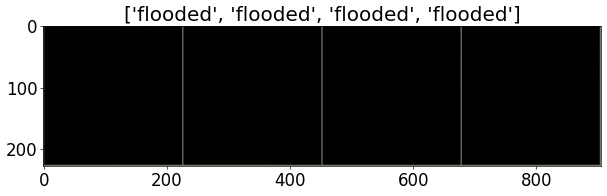

[Test #19] Loss: 2.7294 Acc: 50.0000% Time: 1.4381s


In [80]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
##Testing
model.eval()
start_time = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        if i == 0:
            print('======>RESULTS<======')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.
          format(epoch, epoch_loss, epoch_acc, time.time() - start_time))